###  Bayeisian averaging adjustment for five star rating system

In [1]:
import os
import heapq

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from operator import itemgetter

In [2]:
os.chdir('/Users/lurui/Desktop')

In [3]:
data=pd.read_csv("/Users/lurui/Desktop/Insight/overall.data.csv")

In [4]:
data.columns

Index(['Unnamed: 0', 'Name', 'Speciality', 'Star Rating', 'Staff',
       'Punctuality', 'Helpfulness', 'Knowledge', 'comment',
       'Rating Usefulness', 'Review Date', 'Link', 'text_length',
       'trim_comment', 'neg', 'neu', 'pos', 'compound', 'polarity',
       'subjectivity', 'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib',
       'Keywords', 'Text', 'Positive Sentiment', 'Negative Sentiment'],
      dtype='object')

In [5]:
data.head(5)

,Unnamed: 0,Name,Speciality,Star Rating,Staff,Punctuality,Helpfulness,Knowledge,comment,Rating Usefulness,...,compound,polarity,subjectivity,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Positive Sentiment,Negative Sentiment
0,0,Dr. Natan Schleider,Family Doctor / G.P.,5.0,5,5.0,5,5.0,I thought was extremely caring and attentive...,['0'],...,0.8883,0.233750,0.818333,0,2.0,0.3777,"staff, care, doctor, patient, office, time, go...","['think', 'extremely', 'care', 'attentive', 'n...",True,False
1,1,Dr. Natan Schleider,Family Doctor / G.P.,5.0,5,5.0,5,5.0,"was friendly, punctual, and super nice. He e...",['0'],...,0.8748,0.227083,0.377381,1,2.0,0.3602,"staff, care, doctor, patient, office, time, go...","['friendly', 'punctual', 'super', 'email', 'la...",True,False
2,2,Dr. Natan Schleider,Family Doctor / G.P.,5.0,5,5.0,5,5.0,My experience with was the opposite of every...,['0'],...,0.9118,0.000000,0.000000,2,2.0,0.3879,"staff, care, doctor, patient, office, time, go...","['experience', 'doctor', 'past_experiences', '...",True,False
3,3,Dr. Natan Schleider,Family Doctor / G.P.,5.0,5,5.0,5,5.0,very good. Very knowledgeable and friendly wit...,['0'],...,0.7506,0.375000,0.500000,3,2.0,0.3933,"staff, care, doctor, patient, office, time, go...","['knowledgeable', 'friendly', 'manner', 'highl...",True,False
4,4,Dr. Natan Schleider,Family Doctor / G.P.,4.0,5,5.0,5,1.0,is very knowledgeable and friendly with an e...,['0'],...,0.7506,0.375000,0.500000,4,2.0,0.3933,"staff, care, doctor, patient, office, time, go...","['knowledgeable', 'friendly', 'manner', 'highl...",True,False


In [6]:
ratings=data[["Name","Star Rating","Staff","Punctuality","Helpfulness","Knowledge"]].dropna()

In [7]:
ratings.shape

(12529, 6)

In [8]:
ratings

,Name,Star Rating,Staff,Punctuality,Helpfulness,Knowledge
0,Dr. Natan Schleider,5.00,5,5.0,5,5.0
1,Dr. Natan Schleider,5.00,5,5.0,5,5.0
2,Dr. Natan Schleider,5.00,5,5.0,5,5.0
3,Dr. Natan Schleider,5.00,5,5.0,5,5.0
4,Dr. Natan Schleider,4.00,5,5.0,5,1.0
...,...,...,...,...,...,...
12524,Dr. Douglas A. Taranow,1.50,5,5.0,5,5.0
12525,Dr. Douglas A. Taranow,2.75,5,4.0,5,5.0
12526,Dr. Douglas A. Taranow,5.00,5,4.0,5,5.0
12527,Dr. Douglas A. Taranow,5.00,0,5.0,5,5.0


In [ ]:
ratings.to_csv('ratings.csv', index=False)

### Bayesian Model Averaging Class

In [10]:
PATH= os.path.join(os.path.dirname("/Users/lurui/"), 'Desktop/Insight/ratings.csv')
PRIOR = [2, 2, 2, 2, 2] ### uniform prior 

In [13]:
class Ratings(object):
    """
    An analytical wrapper that manages access to the data and wraps various
    statistical functions for easy and quick evaluation.
    """

    def __init__(self, path=PATH, m=None, C=None):
        self.path  = path
        self.prior = m
        self.confidence = C
        self.load()

    def load(self):
        """
        Load data from disk into a DataFrame.
        """
        self.data = pd.DataFrame(pd.read_csv(self.path))

    def bayesian_mean(self, arr):
        """
        Computes the Bayesian mean from the prior and confidence.
        """
        if not self.prior or not self.confidence:
            raise TypeError("Bayesian mean must be computed with m and C")

        return (self.confidence * self.prior + arr.sum()) / (self.confidence + arr.count())

    @property
    def doctors(self):
        """
        Returns the data grouped by doctors
        """
        return self.data.groupby('Name')

    def get_means(self):
        return self.doctors['Star Rating'].mean()

    def get_counts(self):
        return self.doctors['Star Rating'].count()

    def get_bayesian_estimates(self):
        return self.doctors['Star Rating'].agg(self.bayesian_mean)

    def top_doctors(self, n=1000):
        grid   = pd.DataFrame({
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()})
        return (grid.iloc[grid['bayes'].argsort()[-n:]])

    def plot_mean_frequency(self):
        grid   = pd.DataFrame({
                    'Mean Rating':  self.doctors['Star Rating'].mean(),
                    'Number of Reviewers': self.doctors['Star Rating'].count()
                 })
        grid.plot(x='Number of Reviewers', y='Mean Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=15, mincnt=2,
                  title="Star Ratings by Simple Mean")
        plt.show()
    
    
if __name__ == '__main__':
    over_all_ratings=[]
    ratings = Ratings(m=4.5, C=10) ### confidence 10 with prior 4.5
    over_all_ratings.append(ratings.top_doctors())

In [14]:
adjusted_rating_data=pd.DataFrame(over_all_ratings[0])

In [15]:
adjusted_rating_data

,mean,count,bayes
Name,,,
Dr. Cherry Ostrager,2.744444,45,3.063636
Dr. Tamara Guichard,2.312500,12,3.306818
Dr. Michael H. Aziz,3.243056,36,3.516304
Dr. Eric R. Braverman,3.380714,70,3.520625
Dr. Megan Thomasch,2.772727,11,3.595238
...,...,...,...
Dr. Benjamin N. Metrick,4.987342,79,4.932584
Dr. Imad E. Ayoubi,5.000000,85,4.947368
Dr. Andrew D. Frangella,5.000000,106,4.956897


Text(0.5, 0, 'ratings')

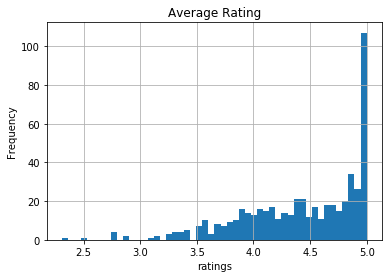

In [16]:
### Before adjustment 
adjusted_rating_data["mean"].hist(bins=50)
plt.title("Average Rating")
plt.ylabel("Frequency")
plt.xlabel("ratings")

Text(0.5, 0, 'ratings')

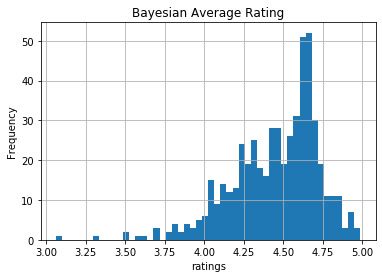

In [17]:
### After adjustment 
adjusted_rating_data["bayes"].hist(bins=50)
plt.title("Bayesian Average Rating")
plt.ylabel("Frequency")
plt.xlabel("ratings")

In [ ]:
import os
os.chdir('/Users/lurui/Desktop/Insight')

In [ ]:
adjusted_rating_data

In [ ]:
adjusted_rating_data.to_csv(r'adjusted_rating_data.csv', encoding='utf8')